In [123]:
import matplotlib
import  pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression 

## Initilization

In [124]:
df =  pd.read_csv(os.getcwd() +"/data/data.csv",index_col=0)

In [125]:
common_categories = ['category','agent_type','type','folder']

regexp_code = re.compile(r'analizo_(.)*(mean|median|quantile_upper)')
regexp_loc = re.compile(r'analizo_loc_(.)*') 
df = df[[c for c in df.columns if  ( regexp_code.search(c) and not regexp_loc.search(c) ) or  c in common_categories]].copy()

## Removing ACCM outliners 

In [126]:
low = .01
high = 0.97
quant_df = df['analizo_accm_mean'].quantile([low, high])
quant_df

0.01    1.111587
0.97    7.116929
Name: analizo_accm_mean, dtype: float64

In [127]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

In [128]:
import collections
def calculate_accurarcy(df,pred,Y,code_class):
    df_merged_acc = df.groupby('type_wrong').count().iloc[:,1]
    pred_robo_cont = collections.Counter(pred)[code_class]
    Y_robo_cont = collections.Counter(Y)[code_class]
    #calculate accurarcy 
    true_pos = float(df_merged_acc.loc[code_class]) if code_class in df_merged_acc.index else 0.0
    
    prec = true_pos / pred_robo_cont if pred_robo_cont >0 else 0 
    recall = true_pos / Y_robo_cont if Y_robo_cont > 0  else 0 
    print 'prec : '  , prec , 'recall :'  , recall , 'f1 :' , (2*(prec*recall)/(prec+recall)) if prec+recall >0 else 0
    
def set_wrong_type(pred,Y,df,type_class):
    df.loc[:,'wrong'] = False
    df.loc[(pred != Y),'wrong'] = True    
    df.loc[(pred != Y) & (df['ml_type'] == type_class),'type_wrong'] = 'wrong_' +type_class    
    df.loc[(pred == Y) & (df['ml_type'] == type_class),'type_wrong'] = type_class
    df.loc[(pred != Y) & (df['ml_type'] == 'others'),'type_wrong'] = 'wrong_others'
    df.loc[(pred == Y) & (df['ml_type'] == 'others'),'type_wrong'] = 'others'
    df['pred']  = Y
    return df
def classify_one_vs_many(df,model,type_class):   
    GH_df_reduced_one_vs_many = df.copy()
    others_df = GH_df_reduced_one_vs_many[(GH_df_reduced_one_vs_many['agent_type']=='non-agent') ].copy()
    from collections import Counter
    print('Training target statistics: {}'.format(Counter(others_df['category'])))
    others_df.loc[:,'ml_type'] = 'others'
    category_df = GH_df_reduced_one_vs_many[GH_df_reduced_one_vs_many['agent_type']==type_class].copy()
    category_df.loc[:,'ml_type'] =type_class      
    df_merged = pd.concat([others_df,category_df],ignore_index=True)

    #print df_merged.groupby(['ml_type','category'])['analizo_accm_mean'].count()
    X = df_merged.select_dtypes(include=[np.number])
    y = df_merged.loc[:,'ml_type']
    ros = RandomOverSampler(random_state=0)
    X_resampled, Y_resampled = ros.fit_resample(X, y)
   
    print('Training target statistics: {}'.format(Counter(Y_resampled)))

    
    model.fit(X_resampled,Y_resampled)
    print model.score(X,y)
    rfe = RFE(model, 4)
    fit = rfe.fit(X, y)
    print "Selected features : " + str(X.columns[fit.support_])
    pred = model.predict(X)
    print Counter(pred)
    df_accurarcy  = set_wrong_type(pred,y, df_merged,type_class)
    calculate_accurarcy(df_accurarcy,pred,y,type_class)
    return df_accurarcy , X.columns[fit.support_].values , model

# Accurercy : 

In [129]:

model  = LinearSVC()
df_accurarcy, selected_features,model = classify_one_vs_many(df_reduced,model,'agent')

Training target statistics: Counter({'Graphics': 58, 'Security': 58, 'Ide': 53, 'Education': 49, 'Audio': 49, 'Mobile': 38, 'Games': 33, 'Finance': 26, 'Robot-Simulation': 22})
Training target statistics: Counter({'agent': 386, 'others': 386})
0.8276553106212425


/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/

Selected features : Index([u'analizo_accm_quantile_upper', u'analizo_dit_mean',
       u'analizo_dit_quantile_median', u'analizo_noc_mean'],
      dtype='object')
Counter({'others': 378, 'agent': 121})
prec :  0.611570247934 recall : 0.654867256637 f1 : 0.632478632479


/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/python2.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/alon/.virtualenvs/vealon/workspace1/local/lib/

In [130]:
selected_features

array(['analizo_accm_quantile_upper', 'analizo_dit_mean',
       'analizo_dit_quantile_median', 'analizo_noc_mean'], dtype=object)

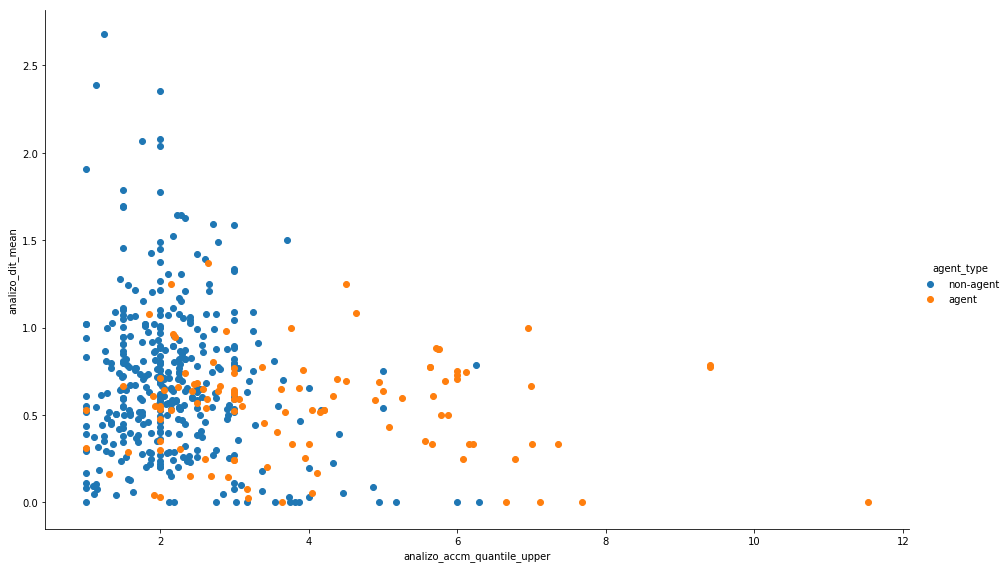

In [94]:
fg = sns.FacetGrid(data=df_accurarcy, hue='agent_type',  aspect=1.61,height=8)
fig = fg.map(plt.scatter, 'analizo_accm_quantile_upper','analizo_dit_mean',).add_legend()

In [95]:
selected_features

array(['analizo_accm_quantile_upper', 'analizo_dit_mean',
       'analizo_dit_quantile_median', 'analizo_noc_mean'], dtype=object)

In [96]:
df_accurarcy.groupby('type_wrong').count()

,analizo_acc_mean,analizo_acc_quantile_median,analizo_acc_quantile_upper,analizo_accm_mean,analizo_accm_quantile_median,analizo_accm_quantile_upper,analizo_amloc_mean,analizo_amloc_quantile_median,analizo_amloc_quantile_upper,analizo_anpm_mean,...,analizo_sc_mean,analizo_sc_quantile_median,analizo_sc_quantile_upper,folder,category,agent_type,type,ml_type,wrong,pred
type_wrong,,,,,,,,,,,,,,,,,,,,,
agent,96,96,96,96,96,96,96,96,96,96,...,96,96,96,96,96,96,96,96,96,96
others,343,343,343,343,343,343,343,343,343,343,...,343,343,343,343,343,343,343,343,343,343
wrong_agent,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
wrong_others,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43


In [97]:
from mlxtend.plotting import plot_decision_regions
df_accurarcy_2 = df_accurarcy[['analizo_accm_mean','analizo_dit_mean']].values

In [134]:
clf = SVC()
Y = df_accurarcy['agent_type'].astype('category').cat.codes.values
clf.fit(df_accurarcy_2,Y)
# Z = clf.predict(df_accurarcy_2.astype(df_accurarcy_2.dtype))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Text(0.5,1,'Classification of agent types')

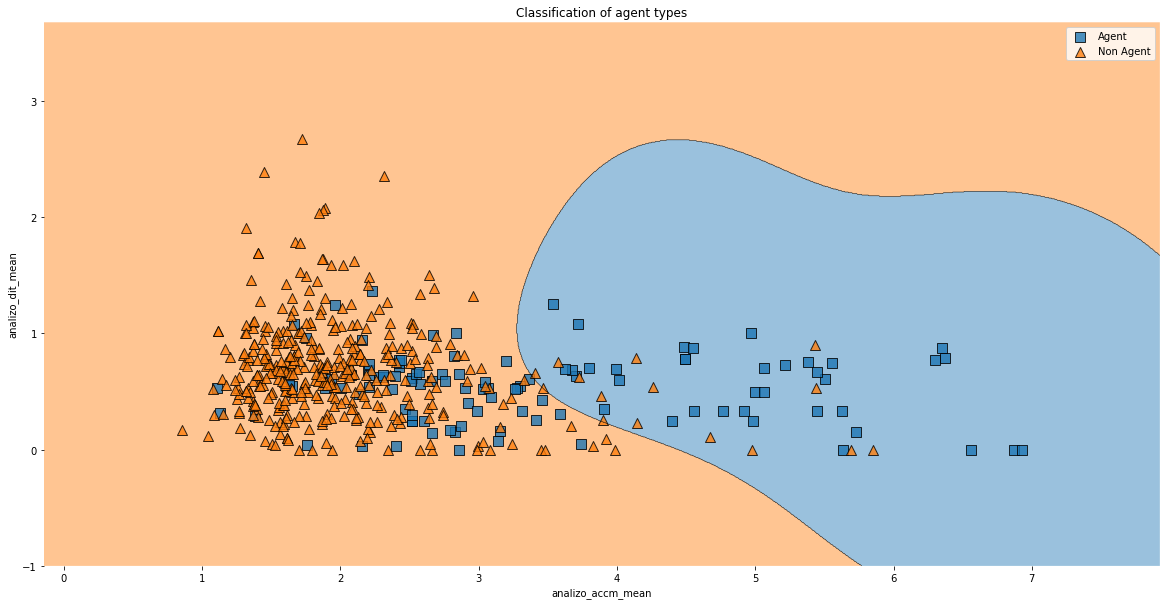

In [135]:
plt.figure(figsize=(20,10))
with plt.style.context({'lines.markersize': 10}):
    ax = plot_decision_regions(df_accurarcy_2,Y,clf=clf)
L=plt.legend()
L.get_texts()[0].set_text('Agent')
L.get_texts()[1].set_text('Non Agent')

# Adding axes annotations
plt.xlabel('analizo_accm_mean')
plt.ylabel('analizo_dit_mean')
plt.title('Classification of agent types')

In [103]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
tsne_results = tsne.fit_transform(df_accurarcy.select_dtypes(include=[np.number]).values)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 499 samples in 0.000s...
[t-SNE] Computed neighbors for 499 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 499 / 499
[t-SNE] Mean sigma: 11.150637
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.723568
[t-SNE] KL divergence after 300 iterations: 0.334103
t-SNE done! Time elapsed: 1.13264513016 seconds


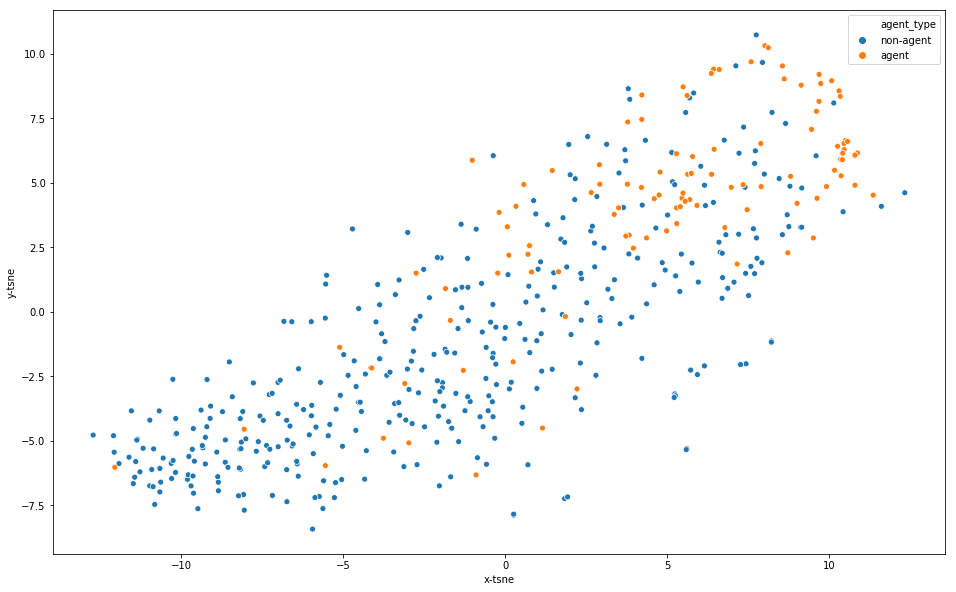

In [104]:
df_accurarcy['x-tsne'] = tsne_results[:,0]
df_accurarcy['y-tsne'] = tsne_results[:,1]
fig,ax = plt.subplots(figsize=(16,10))
sns.scatterplot(ax=ax,data=df_accurarcy,x='x-tsne',y='y-tsne' ,hue='agent_type')